# Step 1.: Embedding each tweet in the time periods

In [ ]:
from utils.preprocess_dataset import pre_processing_feature_extraction
from utils.finetuned_embedding import get_pre_classifier_output
from tqdm import tqdm
import pandas as pd
import os

In [ ]:
tqdm.pandas()

files = os.listdir('cleaned_data/final_approach/train_data')
for i, filename in enumerate(files):
    print(f"Processing {filename} ({i+1}/{len(files)})")
    if filename.endswith('.csv'):
        df = pre_processing_feature_extraction(f'cleaned_data/final_approach/train_data/{filename}', "train")
        df["Embeddings"] = df["Tweet"].progress_apply(get_pre_classifier_output)
        filename = filename.replace('.csv', '.pkl')
        df[["ID", "Embeddings", "EventType"]].to_pickle(f'processed_data/train_data/{filename}')
        print(f"Saved {filename} to processed_data/train_data")
        del df

In [ ]:
files = os.listdir('cleaned_data/final_approach/eval_data')
for i, filename in enumerate(files):
    print(f"Processing {filename} ({i+1}/{len(files)})")
    if filename.endswith('.csv'):
        df = pre_processing_feature_extraction(f'cleaned_data/final_approach/eval_data/{filename}', mode='eval')
        df["Embeddings"] = df["Tweet"].progress_apply(get_pre_classifier_output)
        filename = filename.replace('.csv', '.pkl')
        df[["ID", "Embeddings"]].to_pickle(f'processed_data/eval_data/{filename}')
        print(f"Saved {filename} to processed_data/eval_data")
        del df

# Step 2.: Performing K-Means for each time period on the embedded tweets

In [1]:
import pandas as pd 
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import os
from tqdm import tqdm

def cluster_embeddings(embeddings, n_clusters = 9, standardize = False):
    
    if standardize:
        mean = embeddings.mean(axis=0)
        std = embeddings.std(axis=0)
        embeddings = (embeddings - mean) / std

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    centroids_count = np.bincount(kmeans.labels_)
    return kmeans.cluster_centers_, centroids_count



In [2]:
train_data = pd.DataFrame([])

for file in tqdm(os.listdir('processed_data/train_data')):
    if file.endswith('.pkl'):
        df = pd.read_pickle(f'processed_data/train_data/{file}')
        train_data = pd.concat([train_data, df], ignore_index=True)
        del df


100%|██████████| 16/16 [00:01<00:00,  8.62it/s]


In [ ]:
# from sklearn.decomposition import PCA

# def explained_variance(embeddings, n_components=5):
#     pca = PCA(n_components=n_components)
#     pca.fit(embeddings)
#     return pca.explained_variance_ratio_

# tqdm.pandas()
# train_data["Explained Variance (PCA = 2)"] = train_data["Embeddings"].progress_apply(lambda x: explained_variance(x, 5))
# train_data["Explained Variance"] = train_data["Explained Variance (PCA = 2)"].apply(sum)
# train_data.describe()

In [3]:
tqdm.pandas()
train_data["Clusters"] = train_data["Embeddings"].progress_apply(cluster_embeddings)
train_data.drop(columns=["Embeddings"], inplace=True)

100%|██████████| 2137/2137 [01:48<00:00, 19.63it/s] 


In [47]:
from scipy.spatial.distance import euclidean
import torch
from torch_geometric.data import Data

def construct_graph_for_gnn(input, normalize_weights=False):
    """
    Constructs a graph from centroids and cluster sizes for use in a Graph Neural Network.

    Parameters:
    centroids (np.ndarray): Array of centroid coordinates (n_clusters, embedding_dim).
    cluster_sizes (list): List of cluster sizes (n_clusters).

    Returns:
    torch_geometric.data.Data: A graph data object with node features, edge index, and edge weights.
    """
    centroids, cluster_sizes = input
    n = len(centroids)
    edges = []
    raw_weights = []

    if not normalize_weights:
        cluster_sizes = cluster_sizes / sum(cluster_sizes)

    # Step 1: Compute raw weights and edges
    for i in range(n):
        for j in range(i + 1, n):
            distance = euclidean(centroids[i], centroids[j])
            weight = (cluster_sizes[i] + cluster_sizes[j]) / (1 + distance)  # Raw weight
            edges.append((i, j))
            raw_weights.append(weight)

    # Step 2: Normalize weights
    if normalize_weights:
        raw_weights = torch.tensor(raw_weights, dtype=torch.float)
        min_weight = raw_weights.min()
        max_weight = raw_weights.max()
        normalized_weights = (raw_weights - min_weight) / (max_weight - min_weight)
    else:
        normalized_weights = torch.tensor(raw_weights, dtype=torch.float)

    # Step 3: Prepare edge index and edge attributes
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # Edge index tensor
    edge_attr = normalized_weights  # Normalized weights as edge attributes

    # Step 4: Prepare node features
    x = torch.tensor(centroids, dtype=torch.float)  # Node features (centroids)

    # Step 5: Create PyTorch Geometric Data object
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return graph

In [48]:
trial_1 = construct_graph_for_gnn(train_data[train_data["EventType"] == 0]["Clusters"][0])
trial_2 = construct_graph_for_gnn(train_data[train_data["EventType"] == 1]["Clusters"][5])

In [49]:
trial_1.edge_attr

tensor([0.0344, 0.0444, 0.0393, 0.0136, 0.0294, 0.0143, 0.0239, 0.0218, 0.0812,
        0.0671, 0.0172, 0.0328, 0.0455, 0.0232, 0.0318, 0.0571, 0.0205, 0.0482,
        0.0330, 0.0288, 0.0333, 0.0169, 0.0302, 0.0266, 0.0237, 0.0403, 0.0183,
        0.0083, 0.0177, 0.0099, 0.0163, 0.0272, 0.0205, 0.0111, 0.0133, 0.0140])

In [50]:
trial_2.edge_attr

tensor([0.0101, 0.0084, 0.0122, 0.0102, 0.0087, 0.0155, 0.0095, 0.0105, 0.0237,
        0.0321, 0.0434, 0.0434, 0.0632, 0.0479, 0.0146, 0.0298, 0.0201, 0.0190,
        0.0417, 0.0199, 0.0152, 0.0345, 0.0312, 0.0569, 0.0258, 0.0232, 0.0407,
        0.0438, 0.0314, 0.0153, 0.0535, 0.0440, 0.0129, 0.0541, 0.0237, 0.0129])

# Step 3.: Train the Graph Neural Network on the new representation

In [55]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def create_dataloaders(data, labels, batch_size=16, test_size=0.2, random_state=42):
    """
    Creates PyTorch Geometric DataLoaders from a dataset.

    Parameters:
    - data (list of tuples): Each tuple contains (centroids, cluster_sizes).
    - labels (list of int): Corresponding binary labels (0 or 1) for each graph.
    - batch_size (int): Batch size for the DataLoader.
    - test_size (float): Fraction of data to be used for validation.
    - random_state (int): Seed for reproducibility.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - val_loader (DataLoader): DataLoader for the validation set.
    """
    graphs = []
    
    # Create graphs using the construct_graph_for_gnn function
    for input_data, label in zip(data, labels):
        graph = construct_graph_for_gnn(input_data)
        graph.y = torch.tensor([label], dtype=torch.float)  # Add label to the graph
        graphs.append(graph)
    
    # Split dataset into training and validation sets
    train_graphs, val_graphs = train_test_split(graphs, test_size=test_size, random_state=random_state)
    
    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size)
    
    return train_loader, val_loader

In [56]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from tqdm import tqdm

class GraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        # Input graph data
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Graph convolution layers
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)

        # Global pooling
        x = global_mean_pool(x, batch)  # Aggregate node embeddings

        # Fully connected layer for classification
        x = self.fc(x)
        return x  # Binary classification


def train(model, train_loader, val_loader, epochs, learning_rate):
    """
    Train a GNN model for binary graph classification on an MPS-based machine.

    Parameters:
    - model (torch.nn.Module): The GNN model to train.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - epochs (int): Number of epochs to train.
    - learning_rate (float): Learning rate for the optimizer.

    Returns:
    - model (torch.nn.Module): Trained model.
    """
    # Device configuration for MPS
    #device = torch.device("cpu")
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    model.to(device)

    # Loss and optimizer
    criterion = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for i, epoch in tqdm(enumerate(range(epochs)), desc="Epochs", unit="epoch"):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            batch = batch.to(device)
            
            optimizer.zero_grad()
            # Forward pass
            out = model(batch)
            loss = criterion(out.squeeze(), batch.y.float())  # Squeeze for binary labels
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            preds = torch.sigmoid(out).squeeze() > 0.5
            correct += (preds == batch.y).sum().item()
            total += batch.y.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        training_losses.append(train_loss)
        training_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                loss = criterion(out.squeeze(), batch.y.float())
                val_loss += loss.item()
                
                # Calculate validation accuracy
                preds = torch.sigmoid(out).squeeze() > 0.5
                correct += (preds == batch.y).sum().item()
                total += batch.y.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total

        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        if i % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    return model, training_losses, validation_losses, training_accuracies, validation_accuracies

In [61]:
# Initialize model
model = GraphClassifier(in_channels=768, hidden_channels=256, num_classes=1)

train_loader, val_loader = create_dataloaders(train_data["Clusters"], train_data["EventType"])

In [62]:
trained_model, training_losses, validation_losses, training_accuracies, validation_accuracies = train(model, train_loader, val_loader, epochs=50, learning_rate=0.01)

Epochs: 1epoch [00:02,  2.44s/epoch]

Epoch 1/50: Train Loss = 0.5960, Train Accuracy = 0.7063, Val Loss = 0.5588, Val Accuracy = 0.7383


Epochs: 11epoch [00:25,  2.32s/epoch]

Epoch 11/50: Train Loss = 0.4547, Train Accuracy = 0.7858, Val Loss = 0.4552, Val Accuracy = 0.7874


Epochs: 21epoch [00:48,  2.33s/epoch]

Epoch 21/50: Train Loss = 0.4276, Train Accuracy = 0.7952, Val Loss = 0.5068, Val Accuracy = 0.7664


Epochs: 31epoch [01:12,  2.34s/epoch]

Epoch 31/50: Train Loss = 0.4101, Train Accuracy = 0.8116, Val Loss = 0.4823, Val Accuracy = 0.7407


Epochs: 41epoch [01:35,  2.31s/epoch]

Epoch 41/50: Train Loss = 0.3679, Train Accuracy = 0.8245, Val Loss = 0.4909, Val Accuracy = 0.7850


Epochs: 50epoch [01:56,  2.33s/epoch]


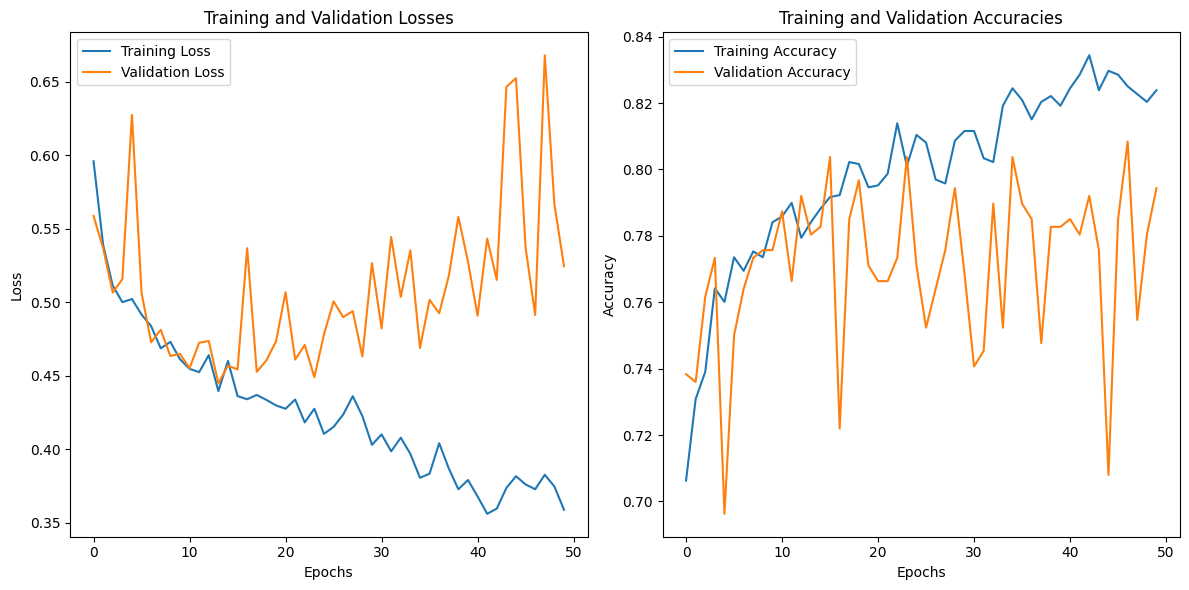

In [63]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

# Step 4.: Evaluation

In [64]:

def infer(model, data_loader, threshold=0.5, device=None):
    """
    Perform inference using the trained GraphClassifier model.

    Parameters:
    - model (torch.nn.Module): Trained GraphClassifier model.
    - data_loader (torch.utils.data.DataLoader): DataLoader containing the test or inference data.
    - threshold (float): Threshold for binary classification. Default is 0.5.
    - device (torch.device): Device to run inference on. Defaults to 'cpu'.

    Returns:
    - predictions (list): Predicted binary labels for each graph.
    - probabilities (list): Predicted probabilities for each graph.
    """
    if device is None:
        device = torch.device("cpu")

    model.eval()  # Set model to evaluation mode
    model.to(device)

    predictions = []

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in data_loader:
            batch = batch.to(device)
            logits = model(batch)  # Forward pass
            probs = torch.sigmoid(logits).squeeze()  # Apply sigmoid for probabilities

            # Convert probabilities to binary predictions
            preds = (probs > threshold).long()


            predictions.extend(preds.cpu().numpy())

    return predictions

In [65]:
eval_data = pd.DataFrame([])

for file in tqdm(os.listdir('processed_data/eval_data')):
    if file.endswith('.pkl'):
        df = pd.read_pickle(f'processed_data/eval_data/{file}')
        eval_data = pd.concat([eval_data, df], ignore_index=True)
        del df


100%|██████████| 4/4 [00:00<00:00, 10.11it/s]


In [66]:
tqdm.pandas()
eval_data["Clusters"] = eval_data["Embeddings"].progress_apply(cluster_embeddings)
eval_data.drop(columns=["Embeddings"], inplace=True)

100%|██████████| 516/516 [00:25<00:00, 19.98it/s]


In [67]:
eval_loader = DataLoader([construct_graph_for_gnn(item) for item in eval_data["Clusters"].values], batch_size=16)

In [68]:
predictions = infer(trained_model, eval_loader)

In [70]:
submission = pd.DataFrame({"ID": eval_data["ID"], "EventType": predictions})

In [73]:
submission.to_csv("model_output/submissions/sub_4/submission.csv", index=False)